In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2024-08-22 09:56:19.707222: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-22 09:56:19.855196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 09:56:19.913269: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 09:56:19.928837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 09:56:20.004295: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1724288182.061213    7436 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724288182.196114    7436 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724288182.196157    7436 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import re
import fasttext

# 데이터 호출 및 파악

In [4]:
df = pd.read_csv('./datasets/ratings.txt', sep='\t', encoding='utf-8')
# df = df[['text', 'label']]
df = df.dropna()
df = df.reset_index(drop=True)
df = df[['document', 'label']]
df.columns=['text','label']

In [5]:
df['label'].value_counts()

label
1    99996
0    99996
Name: count, dtype: int64

In [3]:
def replace_space(sentence):
    new = "".join(["" if ch == " " else ch for ch in sentence])
    return new

In [4]:
# df['text'] = df['text'].apply(replace_space)

In [5]:
df

NameError: name 'df' is not defined

In [ ]:
def is_only_dots(s):
    return all(char == '.' for char in s)

In [ ]:
def is_only_space(s):
    return all(char == ' ' for char in s)

In [ ]:
def is_only_space_hangul(s):
    return all(ord(char) == 12644 for char in s)

In [ ]:
df.shape

In [ ]:
# dot만 포함하는 row
df = df[~df['text'].apply(is_only_dots)]

In [6]:
df.shape

NameError: name 'df' is not defined

In [7]:
df = df[~df['text'].apply(is_only_space)]

NameError: name 'df' is not defined

In [8]:
df.shape

NameError: name 'df' is not defined

In [9]:
df = df[~df['text'].apply(is_only_space_hangul)]

NameError: name 'df' is not defined

In [10]:
df.shape

NameError: name 'df' is not defined

In [11]:
df = df.reset_index(drop=True)

NameError: name 'df' is not defined

In [12]:
# 테스트를 위해 1만개만 샘플링
df = df.sample(n=len(df))
df = df.reset_index(drop=True)
# df = df[:20000]

NameError: name 'df' is not defined

In [13]:
df.shape

NameError: name 'df' is not defined

In [14]:
df

NameError: name 'df' is not defined

In [15]:
counts = df['label'].value_counts()
print(f'Normal speech counts :{counts[0]} ({counts[0]/len(df)*100:.2f}%)')
print(f'Hate speech counts :{counts[1]} ({counts[1]/len(df)*100:.2f}%)')

NameError: name 'df' is not defined

In [16]:
plt.figure(figsize=(12, 6))
print('최대 길이 :', max(len(text) for text in df['text']))
print('최소 길이 :', min(len(text) for text in df['text']))
print('리뷰의 평균 길이 :', sum(df['text'].str.len())/len(df))
plt.hist([len(text) for text in df['text']], bins=200)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

NameError: name 'df' is not defined

<Figure size 1200x600 with 0 Axes>

In [17]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [18]:
threshold = 35

In [19]:
below_threshold_len(threshold, df['text'])

NameError: name 'df' is not defined

In [20]:
counts = df['label'].value_counts()
print(f'Normal speech counts :{counts[0]} ({counts[0]/len(df)*100:.2f}%)')
print(f'Hate speech counts :{counts[1]} ({counts[1]/len(df)*100:.2f}%)')

NameError: name 'df' is not defined

In [21]:
# threshold보다 문장이 작으면 반복적으로 붙여주는 작업을 함
# threshold보다 문장이 길면 슬라이싱을 함
def add_cut_sentence(sentence, threshold):
    cut_list = []
    if len(sentence) >= threshold:
        cut_list = sentence[:threshold]
    else:
        while True:
            if len(cut_list) >= threshold:
                cut_list = cut_list[:threshold]
                break
            cut_list += sentence
    return "".join(cut_list)

In [22]:
# threshold보다 문장이 작으면 반복적으로 붙여주는 작업을 함
# threshold보다 문장이 길면 슬라이싱을 함
def cut_sentence(sentence, threshold):
    cut_list = []
    cut_list = sentence[:threshold]
    return cut_list

In [23]:
# df['text'] = df['text'].apply(lambda text: add_cut_sentence(text, threshold))

In [24]:
# df['text'] = df['text'].apply(lambda text: cut_sentence(text, threshold))

In [25]:
df

NameError: name 'df' is not defined

In [26]:
df.shape

NameError: name 'df' is not defined

# 이미지화

In [27]:
# 이미지로 변환하는 함수
def create_sentence_image(sentence, font_path, font_size, background_color=(0, 0, 0), text_color=(255, 255, 255)):
  sentence_split = sentence.split('\n')
  width = len(max(sentence_split, key=len)) # 길이가 가장 긴 리스트의 길이로 너비 결정
  height = len(sentence_split) # 개행으로 나눠진 리스트의 길이로 높이 결정

  image_width, image_height = (width*16), height*24  # 픽셀 사이즈 조정
  image = Image.new('RGB', (image_width, image_height), background_color)
  draw = ImageDraw.Draw(image)

  # 폰트 호출
  font = ImageFont.truetype(font_path, font_size)

  # Get the text size
  # text_width, text_height = draw.textlength(sentence, font=font)
  _, _, text_width, text_height = draw.textbbox((0, 0), sentence, font=font)

  # Calculate the position to center the text
  x = (image_width - text_width) // 2
  y = (image_height - text_height) // 2

  # Draw the letter on the image
  draw.text((x, y), sentence, font=font, fill=text_color)

  # Convert image to numpy array
  img_array = np.array(image)

  # Find the bounding box of non-background pixels
  non_background = np.where(img_array != background_color)
  top, left = np.min(non_background[0]), np.min(non_background[1])
  bottom, right = np.max(non_background[0]), np.max(non_background[1])

  # Crop the image
  cropped_image = image.crop((left, top, right+1, bottom+1))

  return cropped_image

In [28]:
# 이미지 사이즈 조절. resize
def resize_image(img):
  resized_img = img.resize((32,32))
  return resized_img

In [29]:
# 폰트 설정
font_path = "./utils/arial-unicode.ttf"
font_size = 12

In [30]:
text = "안녕하세요???? 테스트 데이터입니다............."
# text = df['text'][2]
sample = replace_space(text)
# sample = text
img = create_sentence_image(str(sample), font_path, font_size)
resized_img = resize_image(img)
display(img)
img = np.array(img)

In [31]:
print(f"Y axis max value: {img.shape[0]}")
print(f"X axis max value: {img.shape[1]}")

Y axis max value: 11
X axis max value: 237


In [32]:
print(np.array(resized_img).shape)

(32, 32, 3)


# coordinates 추출

In [33]:
# convert image into coordinates
def get_coordinates(img):
  img_arr = np.array(img)
  coordinates = []
  for x in range(len(img_arr)):
    for y in range(len(img_arr[x])):
      if max(img_arr[x][y]) != 0:
        coordinates.append([y,x])
  return np.array(coordinates)

In [34]:
def extract_x_y(img_arr, coordinates):
  # x = np.array([point[0] for point in coordinates]) / len(img_arr[0])
  # y = np.array([point[1] for point in coordinates]) / len(img_arr)
  x = np.array([point[0] for point in coordinates])
  y = np.array([point[1] for point in coordinates])
  # y = 1-y
  return x, y

In [35]:
def draw_text(x, y):
  # plotting
  plt.scatter(x, y, color='blue')

  # Set plot title and labels
  plt.title('Coordinates for Sentence')
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')

  # Display plot
  plt.show()

In [36]:
coordinates = get_coordinates(img)

In [37]:
coordinates.shape

(965, 2)

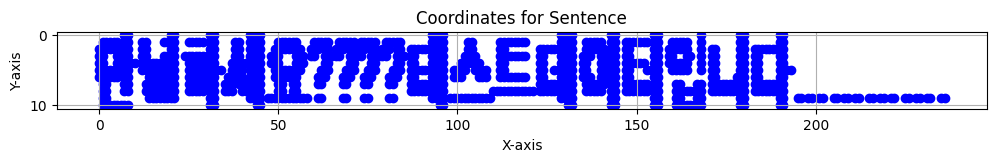

In [38]:
# plotting
import matplotlib.pyplot as plt

x, y = extract_x_y(img, coordinates)

plt.figure(figsize=(12, 1))
plt.scatter(x, y, color='blue')

# Set plot title and labels
plt.title('Coordinates for Sentence')
plt.gca().invert_yaxis()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)  # 그리드 추가

# Display plot
plt.show()

# 좌표값 정규화

In [39]:
def std_coordinates(data, max_x, max_y):
    standardized_data = np.zeros_like(data, dtype=float)
    standardized_data[:, 0] = data[:, 0] / max_x
    standardized_data[:, 1] = data[:, 1] / max_y
    return standardized_data

In [40]:
coordinates[300]

array([130,   3])

In [41]:
img.shape

(11, 237, 3)

In [42]:
std_coords = std_coordinates(coordinates, img.shape[1], img.shape[0])

In [43]:
std_coords.shape

(965, 2)

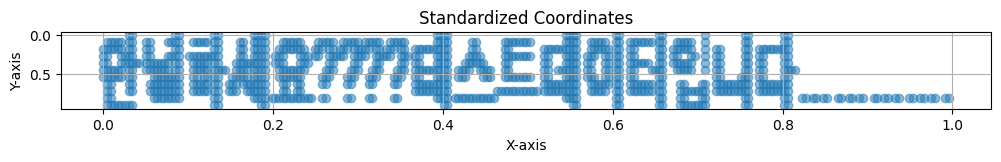

In [44]:
# 산점도 그리기
plt.figure(figsize=(12, 1))
plt.scatter(std_coords[:, 0], std_coords[:, 1], alpha=0.5)
plt.title('Standardized Coordinates')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()
# plt.xlim(0, 1)  # x축 범위를 0에서 1로 설정
# plt.ylim(0, 1)  # y축 범위를 0에서 1로 설정
plt.grid(True)  # 그리드 추가

# 플롯 표시
plt.show()

# 전처리

In [45]:
# 패딩
def pad_coords(coords, pad_size=3000):
    sorted_data = coords[coords[:, 0].argsort()]
    if len(sorted_data) >= pad_size:
        return sorted_data[:pad_size]
    else:
        diff = pad_size - len(sorted_data)
        sorted_data = np.pad(sorted_data, ((0, diff), (0, 0)), mode='constant', constant_values=0)
    return sorted_data

In [46]:
# stopwords 호출
with open('./datasets/stopwords.txt', 'r') as f:
    lines = f.readlines()

# lines = [line.strip() for line in lines]
stopwords = list([line.strip() for line in lines if line != ""][1:])

In [47]:
# fasttext 모델 load
fasttext_model = fasttext.load_model("fasttext_jamo_model.bin")

In [48]:
from jamo import h2j, j2hcj
from konlpy.tag import Okt
okt = Okt()

In [49]:
def vectorize_text(morph_list, model):
    vectors = []
    for i in range(len(morph_list)):
        vectors.append(model[morph_list[i]])
    return vectors

In [50]:
# 정규식 패턴: 같은 문자가 3번 이상 반복되는 경우
def reduce_repeated_chars(s):
    pattern = r'(.)\1{2,}'
    return re.sub(pattern, r'\1\1\1', s)

In [51]:
def get_jamo(s):
    reduced_char = reduce_repeated_chars(s)
    words = okt.morphs(reduced_char, norm=True)
    processed_words = [word for word in words if word not in stopwords]
    jamo_list = [j2hcj(h2j(word)) for word in processed_words]
    return jamo_list

In [52]:
s = '재밌다 ㅋㅋㅋㅋㅋㅋㅋㅋ ㄱ\-ㅈ\- test..... !+ 테스트당 아'
get_jamo(s)

<>:1: SyntaxWarning: invalid escape sequence '\-'
<>:1: SyntaxWarning: invalid escape sequence '\-'
/tmp/ipykernel_5746/3188698262.py:1: SyntaxWarning: invalid escape sequence '\-'
  s = '재밌다 ㅋㅋㅋㅋㅋㅋㅋㅋ ㄱ\-ㅈ\- test..... !+ 테스트당 아'


['ㅈㅐㅁㅣㅆㄷㅏ',
 'ㅋㅋㅋ',
 'ㄱ',
 '\\-',
 'ㅈ',
 '\\-',
 'test',
 '...',
 '!+',
 'ㅌㅔㅅㅡㅌㅡ',
 'ㄷㅏㅇ']

In [3]:
# save processed data
padded_vector_data = np.load('./datasets/padded_vector_data_naver.npy')
coords_data = np.load('./datasets/coords_data_naver.npy')
label_list = np.load('./datasets/label_list_naver.npy')

In [4]:
hate_padded_vector_data = np.load('./datasets/padded_vector_data_hate.npy')
hate_coords_data = np.load('./datasets/coords_data_hate.npy')
hate_label_list = np.load('./datasets/label_list_hate.npy')

In [5]:
padded_vector_data = np.concatenate((padded_vector_data, hate_padded_vector_data), axis=0)
coords_data = np.concatenate((coords_data, hate_coords_data), axis=0)
label_list = np.concatenate((label_list, hate_label_list), axis=0)

In [6]:
print(padded_vector_data.shape)
print(coords_data.shape)
print(label_list.shape)

(389580, 30, 100)
(389580, 3000, 2)
(389580,)


# 데이터 분할

In [7]:
# # 데이터 분할
x_train = padded_vector_data[:330000]
x_train_coords = np.array(coords_data)[:330000]
y_train = np.array(label_list)[:330000]

x_test = padded_vector_data[330000:]
x_test_coords = np.array(coords_data)[330000:]
y_test = np.array(label_list)[330000:]

print(x_train.shape)
print(x_train_coords.shape)
print(y_train.shape)
print(x_test.shape)
print(x_test_coords.shape)
print(y_test.shape)

(330000, 30, 100)
(330000, 3000, 2)
(330000,)
(59580, 30, 100)
(59580, 3000, 2)
(59580,)


# 모델 설계

In [8]:
import tensorflow.keras.layers
from tensorflow.keras.layers import Input, Conv2D, Conv1D, Flatten, Dense, Concatenate, MaxPool2D, MaxPool1D, Dropout, LSTM, Embedding
from tensorflow.keras.models import Model, Sequential

In [ ]:
# # 벡터 입력
# vector_input = Input(shape=(30, 100))
# x1 = LSTM(128, activation='relu')(vector_input)

# # 결합
# img_input = Input(shape=(32,32,3))
# x2 = Conv2D(64, (3,3), activation='relu')(img_input)
# x2 = MaxPool2D()(x2)
# x2 = Dense(128, activation='relu')(x2)
# x2 = Flatten()(x2)

# # 결합
# combined = Concatenate()([x1, x2])
# x3 = Dense(512, activation='relu')(combined)
# output = Dense(1, activation='sigmoid')(x3)

# # 모델 정의
# model = Model(inputs=[vector_input, img_input], outputs=output)

In [9]:
# 벡터 입력
vector_input = Input(shape=(30, 100))
x1 = LSTM(128, activation='relu')(vector_input)
x1 = Flatten()(x1)

# 글자 좌표 입력
coords_input = Input(shape=(3000,2))
x2 = Dense(512, activation='relu')(coords_input)
x2 = Flatten()(x2)  # Flatten the output of Dense layer

# 결합
combined = Concatenate()([x1, x2])
x3 = Dense(128, activation='relu')(combined)
x3 = Dropout(0.4)(x3)
output = Dense(1, activation='sigmoid')(x3)

# 모델 정의
model = Model(inputs=[vector_input, coords_input], outputs=output)

I0000 00:00:1724288670.565813    7436 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724288670.570085    7436 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724288670.570109    7436 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724288673.306436    7436 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724288673.307111    7436 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-22

In [64]:
model = Sequential([
    LSTM(128, input_shape=(30, 100)),
    Dense(1, activation='sigmoid')
])

/home/sdm/miniconda3/envs/dl/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 100)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 3000, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    117,248 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3000, 512) │      1,536 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1536000)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1536128)   │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │ 196,624,5… │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 196,743,425 (750.52 MB)

 Trainable params: 196,743,425 (750.52 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,377 (458.50 KB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
batch_size = 128
epochs = 5

# Train the model
history = model.fit([x_train, x_train_coords], y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5


I0000 00:00:1724288911.655758    7900 service.cc:146] XLA service 0x7efa4c00a1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724288911.656727    7900 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-08-22 10:08:32.037826: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-22 10:08:32.697026: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-22 10:08:33.893654: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1885', 8 bytes spill stores, 8 bytes spill loads

2024-08-22 10:08:34.136138: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function

   4/2321 ━━━━━━━━━━━━━━━━━━━━ 1:37 42ms/step - accuracy: 0.4896 - loss: 4.0426 

I0000 00:00:1724288917.803332    7900 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2319/2321 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7600 - loss: 0.6458

2024-08-22 10:09:38.767140: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44', 452 bytes spill stores, 452 bytes spill loads

2024-08-22 10:09:38.767926: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44', 328 bytes spill stores, 328 bytes spill loads



2321/2321 ━━━━━━━━━━━━━━━━━━━━ 84s 32ms/step - accuracy: 0.7600 - loss: 0.6455 - val_accuracy: 0.9148 - val_loss: 0.2014
Epoch 2/5
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 61s 26ms/step - accuracy: 0.8672 - loss: 0.3228 - val_accuracy: 0.9168 - val_loss: 0.2019
Epoch 3/5
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 64s 28ms/step - accuracy: 0.8836 - loss: 0.2783 - val_accuracy: 0.9272 - val_loss: 0.1818
Epoch 4/5
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 65s 28ms/step - accuracy: 0.8924 - loss: 0.2567 - val_accuracy: 0.9274 - val_loss: 0.1837
Epoch 5/5
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 64s 28ms/step - accuracy: 0.9023 - loss: 0.2318 - val_accuracy: 0.9360 - val_loss: 0.1651


In [67]:
# LSTM model
batch_size = 128
epochs = 5

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.8428 - loss: 0.3574 - val_accuracy: 0.9101 - val_loss: 0.2112
Epoch 2/5
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.8793 - loss: 0.2815 - val_accuracy: 0.9072 - val_loss: 0.2122
Epoch 3/5
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8939 - loss: 0.2515 - val_accuracy: 0.9203 - val_loss: 0.1859
Epoch 4/5
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9033 - loss: 0.2306 - val_accuracy: 0.9312 - val_loss: 0.1709
Epoch 5/5
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9134 - loss: 0.2104 - val_accuracy: 0.9334 - val_loss: 0.1614


# 정확도, 그래프

In [13]:
# Evaluate the model
score = model.evaluate([x_test, x_test_coords], y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.16704612970352173
Test accuracy: 0.9342061281204224


In [68]:
# Evaluate LSTM
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.1612658053636551
Test accuracy: 0.9328297972679138


In [3]:
from sklearn.metrics import f1_score

# y_true: 실제 레이블
# y_pred: 모델이 예측한 레이블
y_pred = model.predict(x_test)
f1 = f1_score(y_test, y_pred)

print("F1 score:", f1)

NameError: name 'model' is not defined

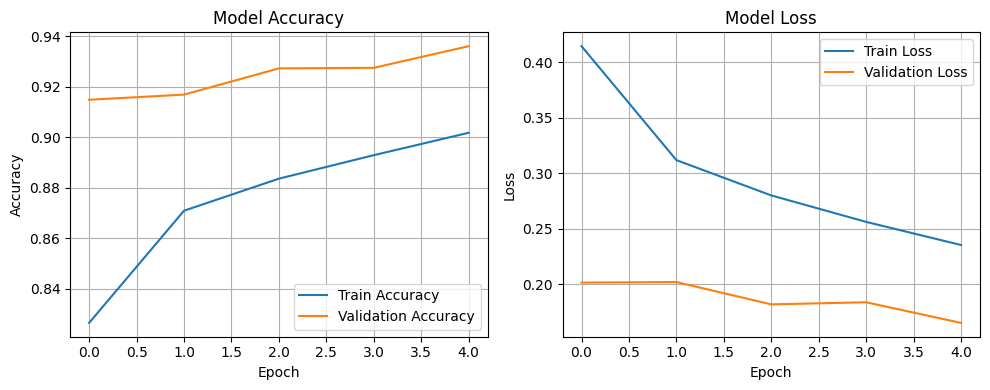

In [63]:
# 벡터, 표표
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1]
# 정확도 그래프
# plt.subplots(1,2,1)
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# 손실 그래프
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

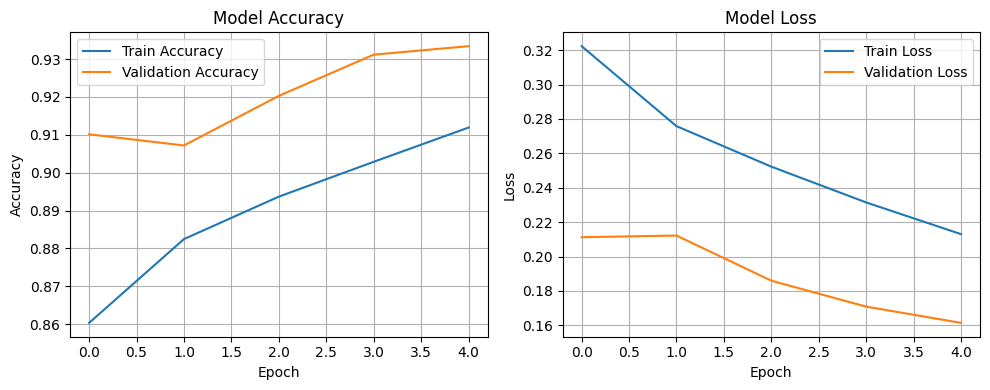

In [69]:
# LSTM
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1]
# 정확도 그래프
# plt.subplots(1,2,1)
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# 손실 그래프
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# 예측 시험

In [102]:
# model.predict()
def predict_model(text):
    sample_processed_text = get_jamo(text)
    sample_vector = vectorize_text(sample_processed_text, fasttext_model)
    if len(sample_vector) == 0:
        return("String data is too short or not available")
    else:
        sample_spaceless_text = replace_space(" ".join(sample_processed_text))
        sample_img = create_sentence_image(sample_spaceless_text, font_path, font_size)
        sample_img = np.array(sample_img)
        
        # 좌표 추출
        sample_coordinates = get_coordinates(sample_img)
        
        x_lim = sample_img.shape[1]
        y_lim = sample_img.shape[0]
        
        # 좌표 정규화
        sample_std_coords = std_coordinates(sample_coordinates, x_lim, y_lim)
        sample_padded_coords = pad_coords(sample_std_coords, pad_size)
    
        # 예측
        sample_padded_vector = pad_vector(sample_vector, 30)

        sample_padded_vector = sample_padded_vector.reshape(1, 30, 100)
        sample_padded_coords = sample_padded_coords.reshape(1, 3000, 2)
        # print(sample_padded_vector.shape)
        # print(sample_padded_coords.shape)
        predict = model.predict([sample_padded_vector, sample_padded_coords], verbose=0)
        return predict

In [183]:
sample = "안녕하세요???? 테스트 데이터입니다............."
data = predict_model(sample)

In [184]:
print(data)

[[0.1550892]]
